<p align="center">
<img src="img/lasair.png" alt="drawing" width="50"/>
</p>
<h1 align="center">  Kafka Tutorial: </h1>
<h2 align="center">  Consuming Public Alerts </h2>


---

## What you'll learn

This notebook will walk you through making your own code to consume alerts from Lasair filters. You will learn:


* A refresher on the basics of kakfa 
* How to set up a kafka consumer with the `lasair` helper function
* What stream options are available for the Lasair filters
* How to navigate the data produced by these stream options. 


## Pre-requesites


### **Have you installed the `lasair` client ?**

You can do this through pip!

```bash
pip install lasair
```

### You also need the following python libraries:
  - `json`
  - `pandas`
  - `matplotlib`
  - `numpy`

---

<h2 align="center">  0. Understanding the Basics of Kafka </h2>

**TL;DR: Kafka allows you to stream the alert data for your chosen Lasair Filters**

The Rubin Observatory sends us (Lasair) alerts continuously through the night in realy time. 
Each alert data is then put in order into the queue of each **filter/topic** it is relevant to (e.g. only alerts cloincident with the Magellanic Clouds, or only Transients coincident with the nucleus of their hosgt galaxy).

Then as a user we can listen to these alerts without ever having to deal with the rest of the Rubin stream.

Because kafka creates a queue **you don't have to me "listening" in real time to catch the alerts**. 
If you have a piece of software or a bot, you can have them run on a cron-job once a day. 
Kafka will **remember your place in the queue** through the means of a `group_id` (see more below). 
If you change `group_id` you will start again at the top of the queue.


#### Q&A:

* _If I start at the beginnign of the queue, does that mean I have to consumer ALL the alerts Rubin has eve sent before I reach today's events?_

**No - topic queues are not infinitely big.** In Lasair they are emptied after **[TBC]** days. 

* _I am looking for alerts that are older than XX days old, what do I do?_

**If you are looking for historical activity, the live stream is probably not what you are looking for.**

Instead you can simply do a database query! (see `API_recipes.ipynb` and further [api/query documentation](https://lasair.readthedocs.io/en/main/core_functions/rest-api.html#--api-query-)).



<h2 align="center">  1. Setting-up your first consumer </h1>



In [149]:
import json, time
import numpy as np
from pathlib import Path
from lasair import LasairError, lasair_consumer
import matplotlib.pyplot as plt
import random # This only needed for the tutorial

### Config for the `lasair_consumer`

To connect to a kafka stream you need a few things:
* The socket (Host:Port) of the server (where is the server on the internet and how do I get into it?): `lasair-lsst-kafka_pub.lsst.ac.uk:9092`
* The endpoint (where are do I send my requests on the server?): `https://api.lasair.lsst.ac.uk/api`
* The topic (corresponding to your filter of choice):  `lasair_18lasair_tutorial_standard_stream`
* The `group_id`, which keeps track of which alerts you've already seen and which ones you have yet to receive. 
* How many alerts (N) are we polling for?


In [98]:
endpoint     = "https://api.lasair.lsst.ac.uk/api"
kafka_server = "lasair-lsst-kafka_pub.lsst.ac.uk:9092"
topic        = "lasair_18lasair_tutorial_standard_stream"
group_id     = "tutorial"+str(int(random.random()*10000000000)) # CREATING RANDOM ID
N            = 3

Now let's use the Lasair client to make our consumer

In [99]:
consumer = lasair_consumer(
    kafka_server,    
    group_id,        
    topic            
)

### Polling your first alerts

In [100]:
n = 0
while n < N: # whilst we have not read N messages
    # ask the lasair consumer to poll the NEXT MESSAGE IN THE QUEUE
    msg = consumer.poll(timeout=20)
    
    if msg is None:
        # If that message is None, we have reached the end of the queue!
        time.sleep(5)
        break

    if msg.error():
        # If there is an error we want to raise an exception
        raise LasairError("Error while consuming message: {}".format(msg.error()))
        break

    # If we have a message we need to read it into Json format
    jmsg = json.loads(msg.value())

    # Then we can write it out!
    print(json.dumps(jmsg, indent=2))
    n += 1
print('You have reached the end of the queue')

{
  "diaObjectId": 170028485651726357,
  "lastDiaSourceMjdTai": 61095.08679945836,
  "latestR": 0.998104,
  "nDiaSources": 96,
  "ra": 65.15242362342809,
  "decl": -48.67535811739442,
  "separationArcsec": 1.281
}
{
  "diaObjectId": 170046083740205236,
  "lastDiaSourceMjdTai": 61095.083764857656,
  "latestR": 0.994066,
  "nDiaSources": 29,
  "ra": 56.87561031015351,
  "decl": -49.85585611465525,
  "separationArcsec": 0.193
}
{
  "diaObjectId": 170028493421150456,
  "lastDiaSourceMjdTai": 61095.079249224,
  "latestR": 0.999899,
  "nDiaSources": 9,
  "ra": 63.738761678813525,
  "decl": -49.58942590823941,
  "separationArcsec": 0.724
}
You have reached the end of the queue


In [101]:
# We're done here so let's tidy up!
consumer.close()

<h2 align="center">  2. Saving the data with the correct format </h2>


In a real life setting you won't be printing large dictionaries to your notebook or terminal, you want it in a `.json` file. 

Let's select an output directory for our data.

**NOTE: I set this tutorial up to point to the /tmp directory** the data will be cleared when you restart your system. Feel free to select a different location

In [102]:
output_dir   = "/tmp/lasair_consumer_output" # this won't work on windows
OUTPUT_PATH = Path(output_dir)
OUTPUT_PATH.mkdir(exist_ok=True, parents=True) # If sub directory doesn't exist, create it. If it does exist, do nothing. If the parent directories don't exist, create them too.

Since we have already listened to our alerts we have moved in the queue! If we want the same alerts we printed above, we need a new `group_id`

In [103]:
group_id     = "tutorial"+str(int(random.random()*10000000000)) # CREATING RANDOM ID

consumer = lasair_consumer(
    kafka_server,    
    group_id,        
    topic            
)

Now we poll and we dump each message in a file which will have the structure:

```
[
    {MESSAGE_ALERT1},
    {MESSAGE_ALERT2},
    ....
    {MESSAGE_ALERTN},
]
```

Each message contains fields and sub-dictionaries.

Now our consumer **is a little more invovled** than it was above, because we need to make sure the brackets and commas are in the right place:

In [ ]:
n = 0
first = True
# To ensure we don't leave out file open we work within a `with` scope
with open(OUTPUT_PATH / f"message_STANDARD.tmp.json", "w", encoding="utf-8") as f:
    # first we write the opening square bracket for the json list
    f.write("[\n")
    while n < N:
        msg = consumer.poll(timeout=20)
        if msg is None:
            break
        if msg.error():
            raise LasairError("Error while consuming message: {}".format(msg.error()))
            break
        # 2. If we make it here it means we have messages. 
        raw = msg.value()
        # msg.value() may be bytes or str depending on client
        if isinstance(raw, bytes):
            raw = raw.decode("utf-8")

        # 3. Get the JSON data for our alert.
        result = json.loads(raw)
        
        # write comma before each object after the first
        if not first:
            f.write(",\n")
        first = False
        
        json.dump(result, f, indent=2, ensure_ascii=False)


        n += 1
    f.write("]\n")


Above we saved the data to a `.tmp.json` file which we will now rename. This practice is called "saving files atomically" and it's a way to not overwrite a good file with corrupted data. If the while loop above breaks halfway through we will be able to tell the good from the bad files. (For example Vim has Swap files for the same reason). 


Once we are happy everything has run properly we can replace our tmp file name with its final name.

In [105]:
# Clean up the temporary files and rename them to .json
import os


os.replace(str(OUTPUT_PATH / f"message_STANDARD.tmp.json"), str(OUTPUT_PATH / f"message_STANDARD.json"))

In [106]:
consumer.close()

<h2 align="center"> 3. Reading a Standard Alert File </h2>

I am going to show you how to handle these with pandas since it already has excellent JSON support. 
This tutorial will not give you a "raw python" solution but you are welcome to suggest updated tutorials via a fork on these examples repository. 

In [107]:
import pandas as pd

Pandas already has a `read_json` function, which works quite well even for nested data structures (which we will need later).

In [108]:
dat = pd.read_json(OUTPUT_PATH/"message_STANDARD.json") 

In [109]:
dat.head()

,diaObjectId,lastDiaSourceMjdTai,latestR,nDiaSources,ra,decl,separationArcsec
0,170028485651726357,61095.086799,0.998104,96,65.152424,-48.675358,1.281
1,170046083740205236,61095.083765,0.994066,29,56.875610,-49.855856,0.193
2,170028493421150456,61095.079249,0.999899,9,63.738762,-49.589426,0.724


As you can see the columns we have here are the same listed in our SQL `SELECT` query for the [Lasair Tutorial Standard Stream Filter](http://lasair.lsst.ac.uk/filters/54/).



![standardfilter](img/standard_stream_filter.png)


---

### 3 types of stream: Standard, Lite Lightcurve, Full Packet

When creating your filter you can select from a few options:
* **Kafka stream**: Just the fields you selected during Filter creation
* **Lite lightcurve**: The fields you selected at filter creation + the lightcurve history 
* **Full Alert**: The fields you selected + the full alert packet. 


In the example above we've only looked at the most essential form of output. 
Now we are going to play with the lightcurve and full alert modes.


[Docs Reference: Alert Streams](https://lasair-lsst.readthedocs.io/en/main/core_functions/alert-streams.html#alert-streams)


---

<h2 align="center"> 5. Lite Lightcurve Alerts</h2>

To get the lite Ligthcruev data we have to **Change our Topic to point to the right filter**. 

In [ ]:
topic = "lasair_18lasair_tutorial_liteLightcurve_stream"

# REMOVE THIS LINE WHEN NOT USING THE TUTORIAL SO YOU DON'T RESTART AT TOP OF THE QUEUE
group_id     = "tutorial"+str(int(random.random()*10000000000)) # CREATING RANDOM ID

We also need to recreate our consumer to point to the right topic

In [111]:
consumer = lasair_consumer(
    kafka_server,    
    group_id,        
    topic            
)

Poll a few alerts, save to file and get them in a data frame, just like before.

In [ ]:
n = 0
first = True
# To ensure we don't leave out file open we work within a `with` scope
with open(OUTPUT_PATH / f"message_LiteLC.tmp.json", "w", encoding="utf-8") as f:
    # first we write the opening square bracket for the json list
    f.write("[\n")
    while n < N:
        msg = consumer.poll(timeout=20)
        if msg is None:
            break
        if msg.error():
            raise LasairError("Error while consuming message: {}".format(msg.error()))
            break
        # 2. If we make it here it means we have messages. 
        raw = msg.value()
        # msg.value() may be bytes or str depending on client
        if isinstance(raw, bytes):
            raw = raw.decode("utf-8")

        # 3. Get the JSON data for our alert.
        result = json.loads(raw)
        
        # write comma before each object after the first
        if not first:
            f.write(",\n")
        first = False
        
        json.dump(result, f, indent=2, ensure_ascii=False)


        n += 1
    f.write("]\n")

os.replace(str(OUTPUT_PATH / f"message_LiteLC.tmp.json"), str(OUTPUT_PATH / f"message_LiteLC.json"))

In [115]:
consumer.close()

In [116]:
dat_llc = pd.read_json(OUTPUT_PATH/"message_LiteLC.json") 

In [117]:
OUTPUT_PATH/"message_LiteLC.json"

PosixPath('/tmp/lasair_consumer_output/message_LiteLC.json')

In [118]:
dat_llc

,diaObjectId,lastDiaSourceMjdTai,latestR,nDiaSources,ra,decl,separationArcsec,UTC,alert
0,170028485651726357,61095.085069,0.998678,96,65.152424,-48.675358,1.281,2026-02-24 09:40:04,{'diaSourcesList': [{'psfFlux': 4487.395996093...
1,170019696272736349,61095.083765,0.993497,198,61.497112,-49.245787,1.560,2026-02-24 09:40:04,{'diaSourcesList': [{'psfFlux': 8182.856933593...
2,313756673035468835,61095.082463,0.991847,135,62.729569,-49.113458,0.165,2026-02-24 09:40:04,{'diaSourcesList': [{'psfFlux': 1386.322631835...


Here we have a new column at the end named `alert`, which contains our **lite lightcurve information**. _The name may seem weird but it's because it's the same column which contains the full alert packet if you ever ask for it (see example below) and keeping column names consistent makes for more robust code._

Let's see what's in there!

In [135]:
dat_llc['alert'].iloc[0].keys()

dict_keys(['diaSourcesList', 'diaForcedSourcesList'])

We have **BOTH** the difference photometry (`diaSourcesList`) and the forced photometry (`diaForcedSourcesList`).
But only a subset of the full tables, just what you need to make ligthcurves!

In [137]:
dat_llc['alert'].iloc[0]['diaSourcesList'][0:3]

[{'psfFlux': 4487.39599609375,
  'psfFluxErr': 229.34771728515625,
  'midpointMjdTai': 61090.04758412875,
  'band': 'i',
  'reliability': 0.9763107895851131},
 {'psfFlux': 4220.04833984375,
  'psfFluxErr': 230.63076782226562,
  'midpointMjdTai': 61090.04845547461,
  'band': 'i',
  'reliability': 0.9671835303306581},
 {'psfFlux': 4002.92626953125,
  'psfFluxErr': 239.22377014160156,
  'midpointMjdTai': 61090.055275032704,
  'band': 'i',
  'reliability': 0.9516166448593141}]

In [139]:
diff_phot = pd.DataFrame(dat_llc['alert'].iloc[0]['diaSourcesList'])
forced_phot = pd.DataFrame(dat_llc['alert'].iloc[0]['diaForcedSourcesList'])

In [140]:
diff_phot.head()

,psfFlux,psfFluxErr,midpointMjdTai,band,reliability
0,4487.395996,229.347717,61090.047584,i,0.976311
1,4220.048340,230.630768,61090.048455,i,0.967184
2,4002.926270,239.223770,61090.055275,i,0.951617
3,4574.646484,254.041229,61090.056141,i,0.973631
4,3986.665039,240.580856,61090.057011,i,0.932570


In [141]:
forced_phot.head()

,psfFlux,psfFluxErr,midpointMjdTai,band
0,4039.206055,242.456390,61090.055275,i
1,4703.056641,260.673920,61090.056141,i
2,4044.197998,244.264221,61090.057011,i
3,3375.168945,246.999908,61090.058774,i
4,4716.489258,267.934662,61090.059639,i


Let's turn our nano janskies to mags:

In [142]:
def nJy2mag(nJy):
    return -2.5 * np.log10(nJy / 3631e9)

In [151]:
diff_phot['mag'] = nJy2mag(diff_phot['psfFlux'])
diff_phot['merr'] = np.abs(1.0857 * diff_phot['psfFluxErr'] / diff_phot['psfFlux'])

forced_phot['mag'] = nJy2mag(forced_phot['psfFlux'])
forced_phot['merr'] = np.abs(1.0857 * forced_phot['psfFluxErr'] / forced_phot['psfFlux'])

/home/stevance/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/stevance/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Make sure we have the right colours for our filters

In [152]:
colour_dict = {'u': '#1600ea', 'g': '#31de1f', 'r': '#b52626', 'i': '#370201', 'z': '#ba52ff', 'y': '#61a2b3'}

In [153]:
diff_phot['colour'] = diff_phot['band'].map(colour_dict)
forced_phot['colour'] = forced_phot['band'].map(colour_dict)

Plot!

Text(0.5, 1.0, 'Difference Photometry Lightcurve (AB Mag)')

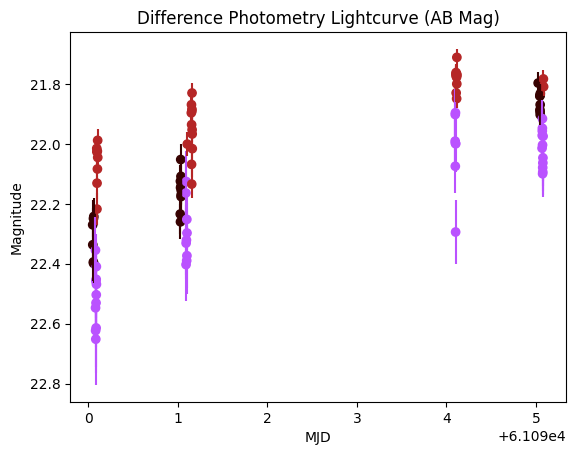

In [150]:
plt.scatter(diff_phot['midpointMjdTai'], 
            diff_phot['mag'], 
            c=diff_phot['colour'])
plt.errorbar(diff_phot['midpointMjdTai'],
            diff_phot['mag'], 
            yerr=diff_phot['merr'], 
            fmt='none', 
            ecolor=diff_phot['colour'])
plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitude')

plt.title('Difference Photometry Lightcurve (AB Mag)')

/home/stevance/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3642: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


Text(0.5, 1.0, 'Forced Photometry Lightcurve (AB Mag)')

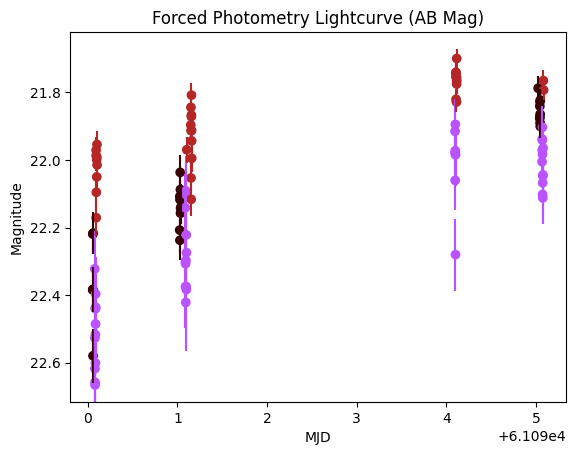

In [154]:
plt.scatter(forced_phot['midpointMjdTai'], 
            forced_phot['mag'], 
            c=forced_phot['colour'])
plt.errorbar(forced_phot['midpointMjdTai'],
            forced_phot['mag'], 
            yerr=forced_phot['merr'], 
            fmt='none', 
            ecolor=forced_phot['colour'])
plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitude')

plt.title('Forced Photometry Lightcurve (AB Mag)')

<h2 align="center"> 6. Mega Stream: <i>Full</i> Packet Data </h2>

"Full" sounds like a good idea until you actually look at it. Here I want to introduce you to it but I cannot walk you through every field - you will have to read the Rubin Alert Packet Schema (relevant sections are sign posted here).

I would recommend making sure you have a very _clear_ idea of why you want all that data before you make or listen to that sort of filter. It gets overwhelming fast. 

If you need information that is in there but are worried about handling the full alert stream, don't hesitate to reach out to us as we may be able to point you to an easier way of obtaining the data (see link to Community forum at the end of this notebook).

In [ ]:
topic = "lasair_18lasair_tutorial_mega_stream"

# REMOVE THIS LINE WHEN NOT USING THE TUTORIAL SO YOU DON'T RESTART AT TOP OF THE QUEUE
group_id     = "tutorial"+str(int(random.random()*10000000000)) # CREATING RANDOM ID

consumer = lasair_consumer(
    kafka_server,    
    group_id,        
    topic            
)
N = 3

In [ ]:
n = 0
first = True
# To ensure we don't leave out file open we work within a `with` scope
with open(OUTPUT_PATH / f"message_FULL.tmp.json", "w", encoding="utf-8") as f:
    # first we write the opening square bracket for the json list
    f.write("[\n")
    while n < N:
        msg = consumer.poll(timeout=20)
        if msg is None:
            break
        if msg.error():
            raise LasairError("Error while consuming message: {}".format(msg.error()))
            break
        # 2. If we make it here it means we have messages. 
        raw = msg.value()
        # msg.value() may be bytes or str depending on client
        if isinstance(raw, bytes):
            raw = raw.decode("utf-8")

        # 3. Get the JSON data for our alert.
        result = json.loads(raw)
        
        # write comma before each object after the first
        if not first:
            f.write(",\n")
        first = False
        
        json.dump(result, f, indent=2, ensure_ascii=False)


        n += 1
    f.write("]\n")

os.replace(str(OUTPUT_PATH / f"message_FULL.tmp.json"), str(OUTPUT_PATH / f"message_FULL.json"))

In [121]:
dat_full= pd.read_json(OUTPUT_PATH/"message_FULL.json") 

In [122]:
OUTPUT_PATH/"message_FULL.json"

PosixPath('/tmp/lasair_consumer_output/message_FULL.json')

In [123]:
dat_full

,diaObjectId,lastDiaSourceMjdTai,latestR,nDiaSources,ra,decl,separationArcsec,UTC,alert
0,313831458387001371,61095.083765,0.996441,195,58.518766,-48.540161,0.350,2026-02-24 09:35:15,{'diaObject': {'diaObjectId': 3138314583870013...
1,170046083740205236,61095.093502,0.994773,33,56.875610,-49.855856,0.193,2026-02-24 09:38:08,{'diaObject': {'diaObjectId': 1700460837402052...
2,313888627043074080,61095.098459,0.957364,352,151.172268,2.772518,8.494,2026-02-24 09:48:18,{'diaObject': {'diaObjectId': 3138886270430740...


Here we have a funky column at the end named `alert`, which contains some heavy nested dictionaries: **THE FULL ALERT FROM RUBIN** (Except the image stamps - we will NEVER send you the stamps through the stream).

Let's see what's in there:

In [124]:
dat_full['alert'].iloc[0].keys()

dict_keys(['diaObject', 'diaSourcesList', 'diaForcedSourcesList', 'diaNondetectionLimitsList', 'ebv'])

We first have the contents of the `diaObject` table (for Schema see Rubin Alert Production [diaObject](https://sdm-schemas.lsst.io/apdb.html#DiaObject))

In [125]:
dat_full['alert'].iloc[0]['diaObject']

{'diaObjectId': 313831458387001371,
 'validityStartMjdTai': 61095.08543523576,
 'ra': 58.51876563741716,
 'raErr': 3.49460169672966e-05,
 'decErr': 3.097404260188341e-05,
 'ra_dec_Cov': 3.550060939661037e-11,
 'u_psfFluxMean': None,
 'u_psfFluxMeanErr': None,
 'u_psfFluxSigma': None,
 'u_psfFluxNdata': 0,
 'u_fpFluxMean': None,
 'u_fpFluxMeanErr': None,
 'g_psfFluxMean': None,
 'g_psfFluxMeanErr': None,
 'g_psfFluxSigma': None,
 'g_psfFluxNdata': 0,
 'g_fpFluxMean': None,
 'g_fpFluxMeanErr': None,
 'r_psfFluxMean': 7578.29443359375,
 'r_psfFluxMeanErr': 28.499849319458008,
 'r_psfFluxSigma': 1819.5623779296875,
 'r_psfFluxNdata': 58,
 'r_fpFluxMean': None,
 'r_fpFluxMeanErr': None,
 'i_psfFluxMean': None,
 'i_psfFluxMeanErr': None,
 'i_psfFluxSigma': None,
 'i_psfFluxNdata': 0,
 'i_fpFluxMean': None,
 'i_fpFluxMeanErr': None,
 'z_psfFluxMean': None,
 'z_psfFluxMeanErr': None,
 'z_psfFluxSigma': None,
 'z_psfFluxNdata': 0,
 'z_fpFluxMean': None,
 'z_fpFluxMeanErr': None,
 'y_psfFluxMean

but a dictionary like that is not very readable - so let's put it in pandas:

In [126]:
__dat  = pd.DataFrame(dat_full['alert'].iloc[0]['diaObject'], index=[0])
__dat.head()

,diaObjectId,validityStartMjdTai,ra,raErr,decErr,ra_dec_Cov,u_psfFluxMean,u_psfFluxMeanErr,u_psfFluxSigma,u_psfFluxNdata,...,z_psfFluxMaxSlope,z_psfFluxErrMean,y_psfFluxMin,y_psfFluxMax,y_psfFluxMaxSlope,y_psfFluxErrMean,firstDiaSourceMjdTai,lastDiaSourceMjdTai,nDiaSources,decl
0,313831458387001371,61095.085435,58.518766,0.000035,0.000031,3.550061e-11,None,None,None,0,...,None,None,None,None,None,None,None,None,195,-48.540161


Then we have the contents of the diaSource table (99 rows) for EACH `diaSourceId` in the history. (see [Rubin Schema for diaSource](https://sdm-schemas.lsst.io/apdb.html#DiaSource)) 

In [127]:
# How many diaSources do we have here?
len(dat_full['alert'].iloc[0]['diaSourcesList'])

195

In [128]:
# First one as a n example
dat_full['alert'].iloc[0]['diaSourcesList'][0]

{'diaSourceId': 313831458387001371,
 'visit': 2025120900398,
 'detector': 144,
 'diaObjectId': 313831458387001371,
 'ssObjectId': None,
 'parentDiaSourceId': 0,
 'midpointMjdTai': 61019.28926317879,
 'ra': 58.518983486542346,
 'raErr': 3.49460169672966e-05,
 'decErr': 3.097404260188341e-05,
 'ra_dec_Cov': 3.550060939661037e-11,
 'x': 910.8436279296875,
 'xErr': 0.629599034786224,
 'y': 2083.057861328125,
 'yErr': 0.555737793445587,
 'centroid_flag': False,
 'apFlux': 1237.91943359375,
 'apFluxErr': 519.6199340820312,
 'apFlux_flag': False,
 'apFlux_flag_apertureTruncated': False,
 'isNegative': False,
 'snr': 5.780348300933838,
 'psfFlux': 1577.6864013671875,
 'psfFluxErr': 273.987060546875,
 'psfLnL': None,
 'psfChi2': 1655.2457275390625,
 'psfNdata': 1681,
 'psfFlux_flag': False,
 'psfFlux_flag_edge': False,
 'psfFlux_flag_noGoodPixels': False,
 'trailFlux': 1492.5899658203125,
 'trailFluxErr': 14.9373140335083,
 'trailRa': 58.518965467272984,
 'trailRaErr': None,
 'trailDec': -48.54

Let's put all our sources into one big table.


In [129]:

df_source_ls = []

# FOR EACH SOURCE
for i in range(len(dat_full['alert'].iloc[0]['diaSourcesList'])):
    # Turns the dictionary into a one row dataframe and append it to the list
    df_source_ls.append(pd.DataFrame(dat_full['alert'].iloc[0]['diaSourcesList'][i], 
                                     index=[i]) # We can also ensure the index makes sense
                                     )

# Then we concatenate our small dataframes into our final table!
# NOTE: This method of concatenation is actually more efficient than concatenanting
# as we go along because for large dataframes, the concatenation creates a copy of the large 
# dataframe each time. So every loop, the process is slowed down. 
df_sources = pd.concat(df_source_ls, ignore_index=True)
df_sources.head()

/tmp/ipykernel_7949/854520610.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sources = pd.concat(df_source_ls, ignore_index=True)


,diaSourceId,visit,detector,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,ra,raErr,decErr,...,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail,decl
0,313831458387001371,2025120900398,144,313831458387001371,None,0,61019.289263,58.518983,0.000035,0.000031,...,False,False,False,False,False,False,False,False,False,-48.540153
1,313893022851923986,2025122300337,146,313831458387001371,None,0,61033.283869,58.518860,0.000015,0.000012,...,False,False,False,False,False,False,False,False,False,-48.540160
2,313893022987714561,2025122300338,149,313831458387001371,None,0,61033.284331,58.518838,0.000011,0.000009,...,False,False,False,False,False,False,False,False,False,-48.540178
3,313897383687618579,2025122400060,84,313831458387001371,None,0,61034.160376,58.518784,0.000006,0.000005,...,False,False,False,False,False,False,False,False,False,-48.540148
4,313897383845953601,2025122400061,130,313831458387001371,None,0,61034.160838,58.518769,0.000005,0.000005,...,False,False,False,False,False,False,False,False,False,-48.540148


Then we have the **Forced Photometry** in `diaForcedSourcesList`, one table for each forced source. See [Rubin Schema for diaForcedSource](https://sdm-schemas.lsst.io/apdb.html#DiaForcedSource)

In [130]:
len(dat_full['alert'].iloc[0]['diaForcedSourcesList'])

166

In [131]:
dat_full['alert'].iloc[0]['diaForcedSourcesList'][0]

{'diaForcedSourceId': 170019696328310855,
 'diaObjectId': 313831458387001371,
 'ra': 58.518775831424605,
 'visit': 2026021600106,
 'detector': 143,
 'psfFlux': 9762.8828125,
 'psfFluxErr': 214.19659423828125,
 'midpointMjdTai': 61088.098045202045,
 'scienceFlux': 31365.037109375,
 'scienceFluxErr': 201.46286010742188,
 'band': 'r',
 'timeProcessedMjdTai': 61088.100084107835,
 'timeWithdrawnMjdTai': None,
 'decl': -48.54016162012997}

Finally we have the extinction, E(B-V).

In [132]:
dat_full['alert'].iloc[0]['ebv']

'0.0076638064'

In [133]:
# Always empty at the minute [TBC]
dat_full['alert'].iloc[0]['diaNondetectionLimitsList']

[]

%4|1772112059.008|MAXPOLL|rdkafka#consumer-20| [thrd:main]: Application maximum poll interval (300000ms) exceeded by 66ms (adjust max.poll.interval.ms for long-running message processing): leaving group


--- 


<h2 align="center"> What's Next </h2>


- If you want to make a consumer script for yourself, you can start with the fully functional and commented sample script under `scripts/kafka_consumer.py`. 

- If you want to get alert data that is not in a kafka queue, **the `API_recipes.ipynb` notebook is for you!**


<h2 align="center"> How to Get Help </h2>

If you have a question or need any help, you can find past questions or as a new one on the **[Community Forum](https://community.lsst.org/c/support/support-lasair/55)**.


![communityforum](img/community_forum.png)
